In [1]:
import pandas as pd
from tqdm.auto import tqdm
from time import time

tqdm.pandas()

In [2]:
def import_labelled_data(path="data/labelled/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data


print("Loading data...")

data = import_labelled_data(
    path="../../data/level-0.5/data.json"
)

print("Data loaded.")


# data = data.sample(2500)

data = data.sample(frac=1).reset_index(drop=True)

data.info()
data.head()

Loading data...


Data loaded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19284 entries, 0 to 19283
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           19284 non-null  object
 1   text          19284 non-null  object
 2   relevance     19284 non-null  object
 3   multiclasses  19284 non-null  object
dtypes: object(4)
memory usage: 602.8+ KB


,url,text,relevance,multiclasses
0,https://www.conservationevidence.com/individua...,"A replicated, site comparison study in 1994–19...",relevant,[Amphibians]
1,https://digitalarchive.worldfishcenter.org/bit...,"h s i F d l r o W / a l a s o P e i n n o R , ...",irrelevant,[]
2,https://www.kanungu.go.ug/sites/default/files/...,DISTRICT PROFILE 2022 1 MAP SHOWING LOCATION O...,irrelevant,[]
3,http://worldwideuniversity.org/library/researc...,RESEARCH METHODS FOR EDUCATIONAL LEADERS Resea...,irrelevant,[]
4,https://www.conservationevidence.com/individua...,Use prescribed burning on pine forestsA site c...,relevant,[Birds]


In [3]:
def train_test_split(x, y=None, test_size=0.2,shuffle=False):
    if shuffle:
        x = x.sample(frac=1).reset_index(drop=True)
    split = int(len(x) * (1 - test_size))
    xTrain, xTest = x.iloc[:split], x.iloc[split:]
    if y is not None:
        yTrain, yTest = y.iloc[:split], y.iloc[split:]
        return xTrain, xTest, yTrain, yTest
    return xTrain, xTest


trainData, testData = train_test_split(data, test_size=0.2) # already shuffled above

In [4]:
trainData.head()

,url,text,relevance,multiclasses
0,https://www.conservationevidence.com/individua...,"A replicated, site comparison study in 1994–19...",relevant,[Amphibians]
1,https://digitalarchive.worldfishcenter.org/bit...,"h s i F d l r o W / a l a s o P e i n n o R , ...",irrelevant,[]
2,https://www.kanungu.go.ug/sites/default/files/...,DISTRICT PROFILE 2022 1 MAP SHOWING LOCATION O...,irrelevant,[]
3,http://worldwideuniversity.org/library/researc...,RESEARCH METHODS FOR EDUCATIONAL LEADERS Resea...,irrelevant,[]
4,https://www.conservationevidence.com/individua...,Use prescribed burning on pine forestsA site c...,relevant,[Birds]


In [5]:
from LogisticRegressionClassifier import LogisticRegressionClassifier


logistic = LogisticRegressionClassifier()



start = time()

logistic.train(trainData)

end = time()

In [6]:
print(f'\n\nTraining time on {len(trainData)} articles: ', end-start, ' seconds')
print(f'\nFiles processed per second: {len(trainData) / (end-start)}')



Training time on 15427 articles:  310.4533121585846  seconds

Files processed per second: 49.69185186892011


In [7]:
def evaluate(classifier):
    predYBools, predYProbabilities = classifier.predict_threshold(testData,threshold=0.5)
    return testData['relevance'].map({'relevant':1, 'irrelevant': 0}),predYBools, predYProbabilities


In [8]:
start = time()

trueYInts, predYBools, predYProbabilities = evaluate(logistic)

end = time()

In [9]:
print(f'\n\nPrediction time on {len(trainData)} articles: ', end-start, ' seconds')
print(f'\nFiles processed per second: {len(trainData) / (end-start)}')



Training time on 15427 articles:  73.51406478881836  seconds

Files processed per second: 209.85099986399445


In [10]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score

def calculate_metrics(trueYInts, predYBools, predYProbabilities):
    return {
            "accuracy": accuracy_score(trueYInts, predYBools),
            "f1": f1_score(trueYInts, predYBools, average='macro',zero_division=0),
            "precision": precision_score(trueYInts, predYBools, average='macro',zero_division=0),
            "confusion_matrix": confusion_matrix(trueYInts, predYBools),
            "predictions": logistic.boolPredictionsToLabels(predYBools.astype('bool').astype(f'<U{len("irrelevant")}')),
            "probabilities": predYProbabilities[:,1]
        }


# need the f'<U{len("irrelevant")}' to ensure the strings don't get
# truncated to the same length as 'False'
# so we set the max length to the length of 'irrelevant'



def format_output(results):
    print(f"Accuracy: {results['accuracy']} \t F1: {results['f1']} \t Precision: {results['precision']} \t")
    print("\n\n")

In [11]:
results = calculate_metrics(trueYInts, predYBools.astype('int32'), predYProbabilities)

format_output(results)

Accuracy: 0.9961109670728545 	 F1: 0.9960647475041193 	 Precision: 0.9962656057938636 	





In [12]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 15427 to 19283
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   url           3857 non-null   object
 1   text          3857 non-null   object
 2   relevance     3857 non-null   object
 3   multiclasses  3857 non-null   object
dtypes: object(4)
memory usage: 120.7+ KB


In [13]:
testData = testData.assign(predictions=results['predictions'], score=results['probabilities'])


In [14]:
testData.info()
testData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 15427 to 19283
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           3857 non-null   object 
 1   text          3857 non-null   object 
 2   relevance     3857 non-null   object 
 3   multiclasses  3857 non-null   object 
 4   predictions   3857 non-null   object 
 5   score         3857 non-null   float64
dtypes: float64(1), object(5)
memory usage: 180.9+ KB


,url,text,relevance,multiclasses,predictions,score
15427,https://theprofessionals.com.pg/storage/pdf/La...,Professionals Commercial - Residential - Land ...,irrelevant,[],irrelevant,0.065118
15428,https://wvculture.org/wp-content/uploads/2021/...,- 2 Page U S D I /NPS NRHP Registration Form P...,irrelevant,[],irrelevant,0.015077
15429,https://www.conservationevidence.com/individua...,Reduce predation by translocating predators A ...,relevant,[Birds],relevant,0.980168
15430,https://www.conservationevidence.com/individua...,Asian clams: Add chemicals to the waterA contr...,relevant,"[Fish, Invasive]",relevant,0.813505
15431,https://repositorio.unheval.edu.pe/bitstream/h...,i UNIVERSIDAD NACIONAL HERMILIO VALDIZÁN FACUL...,irrelevant,[],irrelevant,0.003876


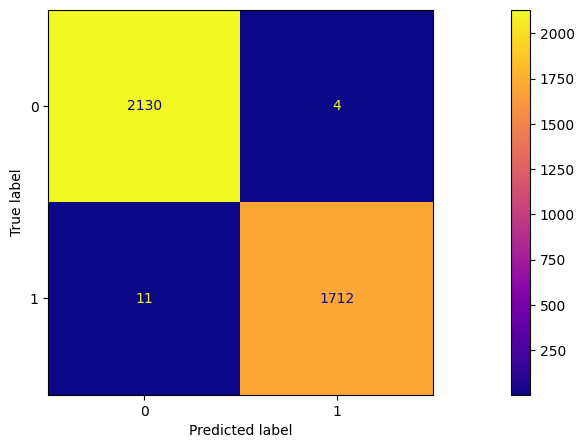

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(testData['relevance'], testData['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()



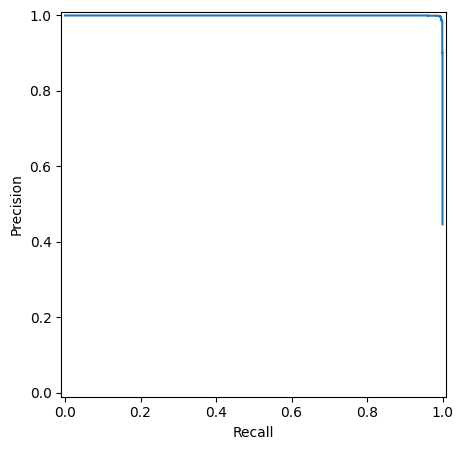

In [16]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(trueYInts, predYProbabilities[:,1])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=axs)

plt.show()


In [17]:
# save logistic regression model

import pickle
import os

if len(data) <= 15000:
    path = 'models/dev/LogisticRegression.pkl'
else:
    path = 'models/LogisticRegression.pkl'

with open(path, 'wb') as f:
    pickle.dump(logistic, f)

